<a href="https://colab.research.google.com/github/aufawibowo/lstm-under-different-stability/blob/master/Notebook_Implementation_of_Stock_Prediction_Based_on_LSTM_under_Different_Stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-work

##Load the library

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import tensorflow
%tensorflow_version 1.x
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import time #helper libraries
print(tensorflow.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0-rc2


## Data source

In [0]:
input_file = "/content/drive/My Drive/tugas akhir/SZSE 200 Historical Data.csv"

## Load the dataset

In [0]:
# load the dataset
df = read_csv(input_file, header=0, index_col=None, delimiter=',')

In [0]:
# take close price column[5]
all_y = df['Price'].values
dataset=all_y.reshape(-1, 1)

In [0]:
dataset_list = [data.tolist() for data in dataset]
dataset_list = [dataset_list[i][0] for i in range(len(dataset))]

# Stationarity detection

## ADF

In [36]:
result = adfuller(dataset_list)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.867969
p-value: 0.798338
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


If `ADF Statistic`'s value is larger than all of the ciritical values at 1%, 5%, and 10% confidence levels, then, we can say that the time series does appear to be **non-stationary** with a low likelihood of the result being a statistical fluke.

## Autocorrelation plot

TypeError: ignored

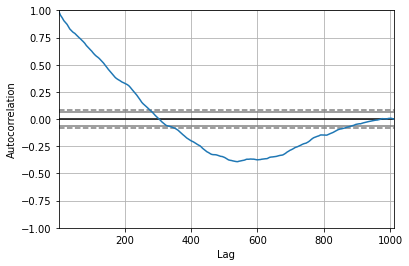

In [39]:
# autocorrelation = autocorrelation_plot(dataset_list)
# plt.plot(autocorrelation)
# plt.show()

#Prediction

## Dataset matrix converter

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

## Normalization

In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Dataset splitting
(training set 70% and test set 30%)
Qian, Fei, and Xianfu Chen. "Stock Prediction Based on LSTM under Different Stability." 2019 IEEE 4th International Conference on Cloud Computing and Big Data Analysis (ICCCBDA). IEEE, 2019.

In [0]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [0]:
look_back = 240
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Creating the LSTM

In [0]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
epochs = 1000
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum = 0.8

model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
model.fit(trainX, trainY, batch_size=240, epochs=1000, verbose=1)

## Make prediction

In [0]:
## make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

## Invert predictions


In [0]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Evaluation

## Calculate root mean squared error

In [0]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %f RMSE' % (testScore))

#Visualization

##  Shift train predictions for plotting

In [0]:
## shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

## Shift test predictions for plotting

In [0]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

## Plot baseline and predictions

In [0]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])

## Plot the actual price, prediction in test data=red line, actual price=blue line

In [0]:
# plot the actual price, prediction in test data=red line, actual price=blue line
plt.plot(testPredictPlot)
plt.show()

## Export prediction and actual prices

In [0]:
print(np.around(list(testPredict.reshape(-1))).size)
print(np.around(list(testPrices.reshape(-1))).size)

In [0]:
# export prediction and actual prices
df = pd.DataFrame(data=
                  {"prediction": np.around(list(testPredict.reshape(-1)), decimals=2), 
                   "test_price": np.around(list(testPrices.reshape(-1)), decimals=2)}
                  )
df.to_csv("lstm_result.csv", sep=',', index=None)